# K-NN - Non-Linear Classifier

In this notebook we investigate the fact that K-NN is a **<font color=red size=6> non-linear classifier </font>** by observing its decision boundary. It can classify non-linear dataset by creating non-inear decision boundary. It doesn't need to augment the dataset (i.e., creating high-dimensional features).


We compare the K-NN decision boundary with **Logistic Regression** decision boundary.

Our goal is to show that for a non-linear dataset, the K-NN model can "learn" very complex (non-linear) decision boundary, while Logistic Regression can only create a linear decision boundary.

- K-NN is inherently a non-linear model.
- Logistic Regression is inherently a linear model.

In [2]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import make_circles
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


# Synthetic Dataset

We will use Scikit-Learn's "datasets.make_circles" function to generate a synthetic non-linear dataset that is suitable for investigating classification (as well as clustering) models. It creates a large circle containing a smaller circle in 2d.

The following two parameters are used by the make_circles function:

- factor : Scale factor between inner and outer circle. Range 0 ~ 1.

- noise : Standard deviation of Gaussian noise added to the data.

## Load The Data and Visualiize 

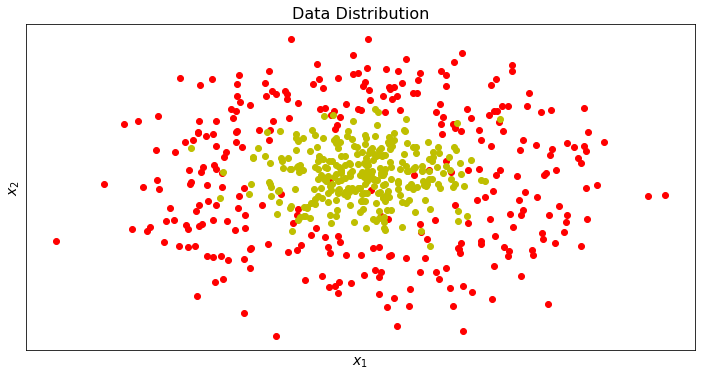

In [44]:
X, y = make_circles(n_samples=600, factor = 0.1, noise=0.3, random_state=0)

plt.figure(figsize=(12, 6))
plt.plot(X[y.ravel()==0, 0], X[y.ravel()==0, 1], "ro")
plt.plot(X[y.ravel()==1, 0], X[y.ravel()==1, 1], "yo")
plt.title("Data Distribution", fontsize=16)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.xticks(())
plt.yticks(())
plt.show()

# Create Training and Test Dataset

In [45]:
# Spilt the dataset into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(480, 2)
(120, 2)
(480,)
(120,)


# Function for Plotting Decision Bounday 


To better understand how the K Nearest Neighbors model classifier performs classifiation, we need to **<font color=red size=6> visualize </font>** its decision boundary.


We define the function "decision_boundary_class_colored" to plot the decision boundary. 

In [46]:
def decision_boundary_class_colored(clf, X, plotDistanceFromHyperplane=False, colorBar=False):
    
    # Get the min and max value of feature x1
    x1min, x1max = X[:,0].min() - 0.1, X[:, 0].max() + 0.1
    
    # Get the min and max value of feature x2
    x2min, x2max = X[:,1].min() - 0.1, X[:, 1].max() + 0.1
    
    # Create the mesh grid
    x1s = np.linspace(x1min, x1max, 100)
    x2s = np.linspace(x2min, x2max, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    
    
    # Create pairs of new points from the grid
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    
    # Compute the class predictions for all new points
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    
    # Generate the contourf plot for the predictions
    plt.contourf(x1, x2, y_pred, cmap=plt.cm.binary, alpha=0.8)
    
    
    if(plotDistanceFromHyperplane == True):
    
        # Compute the signed distance of a sample to the hyperplane for all new points
        y_decision = clf.decision_function(X_new).reshape(x1.shape)

        # Generate the contourf plot for the distance of all points from the hyperplane
        plt.contourf(x1, x2, y_decision, cmap=plt.cm.bwr, alpha=0.2)
    
    if(colorBar==True):
        plt.colorbar()
    

## K-NN Model Selection: Hyperparameter Tunining

For finding optimal K (optimal model) in K-NN, we perform model selection via cross validation.


A K-NN model is defined by a set of parameters: nearest neighbors (K), distance metric (p), etc. These are called hyperparameters.

We need to select the best model based on the optimal values of these hyperparameters. This process is called hyperparameter tuning.

The best way to do hyperparameter tuning is to use cross-validation.

We will use Scikit-Learn’s GridSearchCV to search the combinations of hyperparameter values that provide best performance.

We need to tell which hyperparameters we want the GridSearchCV to experiment with, and what values to try out. It will evaluate all the possible combinations of hyperparameter values, using cross-validation. 


## Important:

The GridSearchCV takes an argument to define the scoring metric (performance measure). 

See the list of possible scoring functions:
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

For multiclass classification, we may use "f1_micro" scoring function. The f1_micro function is the average of the F1 score of each class with weighting depending on the average parameter.

In the binary classification, f1 score function can be used. We may also use the precision, recall, roc_auc functions.



In [47]:
%%time

warnings.filterwarnings('ignore')


# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values 
param_grid = {'n_neighbors': np.arange(1, 37, 2), 'p': [1, 2, 5, 10, 20, 30, 50, 100], 
              'weights': ["uniform", "distance"]}

knn = KNeighborsClassifier()

knn_cv = GridSearchCV(knn, param_grid, scoring='f1', cv=5)
knn_cv.fit(X_train, y_train)


params_optimal_knn = knn_cv.best_params_

print("Best Score: %f" % knn_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_knn)
print("\n")

Best Score: 0.927225
Optimal Hyperparameter Values:  {'p': 1, 'n_neighbors': 5, 'weights': 'uniform'}


CPU times: user 20.1 s, sys: 24.6 ms, total: 20.1 s
Wall time: 20.1 s


## K-NN: Select The Best Model 

Using the optimal hyperparameter values, create the best model.
Then, fit the model.

In [48]:
knn = KNeighborsClassifier(**params_optimal_knn)
knn.fit(X_train, y_train) 

y_train_predicted = knn.predict(X_train)
#print(y_test_predict)

train_accuracy_knn = np.mean(y_train_predicted == y_train)
print("\nTraining Accuracy: ", train_accuracy_knn)


Training Accuracy:  0.9395833333333333


## K-NN: Evaluate The Model Using Test Data

The KNeighborsClassifier model has a default "score" function that computes the accuracy of the model.

Often times the accuracy is not a good measure.

We also compute the other performance measures, such as the confusion matrix, precision, recall, and the F1 score for the test data.

## K-NN: Confusion Matrix for Test Data

In [49]:
# The accuracy of the model
test_accuracy_knn = knn.score(X_test, y_test)
print("\nTest Accuracy: ", test_accuracy_knn)



# No. of Correct Predictions
y_test_predicted = knn.predict(X_test)
print("\nNo. of correct predictions (Test): %d/%d" % (np.sum(y_test_predicted == y_test), len(y_test)))



# Confusion Matrix
print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_test, y_test_predicted))


Test Accuracy:  0.9

No. of correct predictions (Test): 108/120

Confusion Matrix (Test Data):
 [[55  7]
 [ 5 53]]


## K-NN: Precision, Recall & F1 Score for Test Data

In [51]:
precision = precision_score(y_test, y_test_predicted) 
print("Precision = %f" % precision)

recall = recall_score(y_test, y_test_predicted)
print("Recall = %f" % recall)


f1 = f1_score(y_test, y_test_predicted)
print("F1 Score = %f" % f1)


Precision = 0.883333
Recall = 0.913793
F1 Score = 0.898305


# Logistic Regression Model

We train a Logistic Regression model and evaluate its performance.

For training the Logistic Regression model we don't perform model selection. For this highly non-linear data there is no optimal model for Logistic Regression as it's inherently a linear model. Logistic Regression can classify non-linear data only when data is augmented by projecting the features on a high-dimensioal space.

In [52]:
lg_reg_clf = LogisticRegression()

lg_reg_clf.fit(X_train, y_train)


y_train_predicted = lg_reg_clf.predict(X_train)
#print(y_test_predict)


print("Logistic Regression:")

train_accuracy_logreg = np.mean(y_train_predicted == y_train)
print("\nTraining Accuracy: ", train_accuracy_logreg)


y_test_predicted = lg_reg_clf.predict(X_test)


test_accuracy_logreg = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", test_accuracy_logreg)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


precision_test = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_test)


f1_test = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_test)

Logistic Regression:

Training Accuracy:  0.5895833333333333

Test Accuracy:  0.5916666666666667

Test Confusion Matrix:
[[28 34]
 [15 43]]

Test Precision = 0.558442
Test Recall = 0.741379
Test F1 Score = 0.637037


## Decision Boundary: K-NN vs Logistic Regression

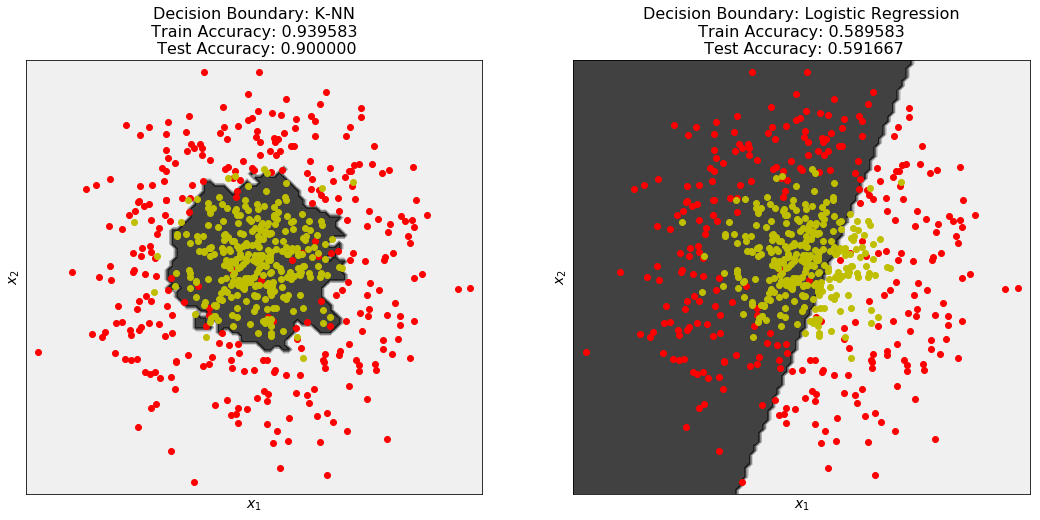

In [53]:
plt.figure(figsize=(18,8))

plt.subplot(121)
decision_boundary_class_colored(knn, X, plotDistanceFromHyperplane=False)
plt.plot(X[y.ravel()==0, 0], X[y.ravel()==0, 1], "ro")
plt.plot(X[y.ravel()==1, 0], X[y.ravel()==1, 1], "yo")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.title("Decision Boundary: K-NN\n Train Accuracy: %f \n Test Accuracy: %f"% 
          (train_accuracy_knn, test_accuracy_knn) , fontsize=16)
plt.xticks(())
plt.yticks(())


plt.subplot(122)
decision_boundary_class_colored(lg_reg_clf, X, plotDistanceFromHyperplane=False)
plt.plot(X[y.ravel()==0, 0], X[y.ravel()==0, 1], "ro")
plt.plot(X[y.ravel()==1, 0], X[y.ravel()==1, 1], "yo")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.title("Decision Boundary: Logistic Regression\n Train Accuracy: %f \n Test Accuracy: %f"% 
          (train_accuracy_logreg, test_accuracy_logreg) , fontsize=16)
plt.xticks(())
plt.yticks(())

plt.show()

## Observation

We see that K-NN creates a non-linear decision boundary while Logistic Regression creates a linear decision boundary.

- Logistic Regression is unable to classify non-linear data (test accuracy is $<60\%$). Because it's a **linear model**.
- K-NN can successfully classify the data with 90% test accuracy. K-NN is able to create such complex decision boundary because it's a **non-linear model**.

However, the **<font color=red size=6> problem </font>** with K-NN is that it requires the entire dataset to make predictions (instance based model). That's why it's very slow on large dataset with large number of features.

There are more sophisticated and efficent non-linear models, such as **Multi-Layer Perceptron (MLP)** and **Decision Tree**.